<a href="https://colab.research.google.com/github/albertokabore/Albert_Healthcare-Claims-Data-Processing-and-Analytics-using-PySpark-on-Databricks/blob/main/PySPark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objectives & Tasks

In [199]:
!pip install pyspark pandas openpyxl matplotlib seaborn pathlib

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


In [201]:
# Install Java and PySpark dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and extract Spark 3.4.1 (confirmed working version)
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar -xvzf spark-3.4.1-bin-hadoop3.tgz > /dev/null

# Install findspark
!pip install -q findspark

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

# Initialize findspark and SparkSession
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("HealthcareClaims").getOrCreate()

print("PySpark is ready!")


PySpark is ready!


In [202]:
# Uncomment and run the following lines in case Google Colab is being used
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [203]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("HealthcareClaims") \
    .getOrCreate()  # <- THIS is the missing part


In [204]:
import os
os.listdir()

['.config',
 'Readmission Rate by A1C Result.png',
 'cleaned_diabetic_data.parquet',
 'spark-3.4.1-bin-hadoop3',
 'avg_time_by_age.png',
 'spark-3.4.1-bin-hadoop3.tgz.4',
 'a1c_readmit.png',
 'spark-3.4.1-bin-hadoop3.tgz',
 'readmit_by_diag1.csv',
 'diabetic_data (1).csv',
 'spark-3.4.1-bin-hadoop3.tgz.3',
 'spark-3.4.1-bin-hadoop3.tgz.2',
 'spark-3.4.1-bin-hadoop3.tgz.5',
 'insulin_readmit.png',
 'diabetic_data.csv',
 'top_diag_readmit.png',
 'drive',
 'spark-3.4.1-bin-hadoop3.tgz.1',
 'avg_time_by_age.csv',
 'Readmission Rate by Insulin Use.png',
 'Top 5 Diagnosis Codes by Readmission Rate.png',
 'a1c_readmit.csv',
 'Avg Time in Hospital by Age Group.png',
 'chart_name.png',
 'insulin_readmit.csv',
 'sample_data']

Step 1: Data Ingestion

In [205]:
# Read CSV using PySpark
df = spark.read.csv("diabetic_data.csv", header=True, inferSchema=True)
print(" Data loaded")
df.printSchema()
df.show(5)

 Data loaded
root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullabl

Step 2: Data Cleansing

In [206]:
# Data Cleansing
from pyspark.sql.functions import col, when

df_cleaned = df.replace('?', None)
df_cleaned = df_cleaned.filter(df_cleaned.gender != "Unknown/Invalid")
print(f" Cleaned data: {df_cleaned.count()} rows")


 Cleaned data: 101763 rows


 Step 3: Data Transformation

In [207]:
# Data Transformation
df_transformed = df_cleaned.withColumn(
    "total_visits",
    col("number_outpatient") + col("number_emergency") + col("number_inpatient")
).withColumn(
    "readmission_flag",
    when(col("readmitted").isin("<30",">30"), 1).otherwise(0)
)
print(" Transformed data sample:")
df_transformed.select("total_visits", "readmission_flag").show(5)


 Transformed data sample:
+------------+----------------+
|total_visits|readmission_flag|
+------------+----------------+
|           0|               0|
|           0|               1|
|           3|               0|
|           0|               0|
|           0|               0|
+------------+----------------+
only showing top 5 rows



Step 4: Exploratory Data Analysis (EDA)

a) Average time in hospital by age

In [208]:
avg_time_by_age = df_transformed.groupBy("age").avg("time_in_hospital").orderBy("age")
print("Average time in hospital by age group:")
avg_time_by_age.show()

Average time in hospital by age group:
+--------+---------------------+
|     age|avg(time_in_hospital)|
+--------+---------------------+
|  [0-10)|    2.546583850931677|
| [10-20)|    3.191027496382055|
| [20-30)|   3.5648762824381413|
| [30-40)|   3.7997350993377483|
| [40-50)|    4.039648941662365|
| [50-60)|    4.125753361149745|
| [60-70)|    4.382394804732675|
| [70-80)|    4.590884677357477|
| [80-90)|    4.808629412106763|
|[90-100)|    4.755818116720373|
+--------+---------------------+



b) Top diagnosis codes with high readmission


In [209]:
readmit_diag1 = df_transformed.groupBy("diag_1").avg("readmission_flag").orderBy(col("avg(readmission_flag)").desc())
print("Top diagnosis codes by readmission rate:")
readmit_diag1.show(5)


Top diagnosis codes by readmission rate:
+------+---------------------+
|diag_1|avg(readmission_flag)|
+------+---------------------+
|   365|                  1.0|
|   V60|                  1.0|
|   878|                  1.0|
|250.52|                  1.0|
|   944|                  1.0|
+------+---------------------+
only showing top 5 rows



c) Readmission rate by insulin use

In [210]:
insulin_readmit = df_transformed.groupBy("insulin").avg("readmission_flag").orderBy("insulin")
print("Readmission rates by insulin use:")
insulin_readmit.show()


Readmission rates by insulin use:
+-------+---------------------+
|insulin|avg(readmission_flag)|
+-------+---------------------+
|   Down|   0.5279096415125225|
|     No|  0.43699873364288727|
| Steady|  0.45106810593536256|
|     Up|   0.5153764581124072|
+-------+---------------------+



d) Readmission rate by A1C result


In [211]:
a1c_readmit = df_transformed.groupBy("A1Cresult").avg("readmission_flag").orderBy("A1Cresult")
print("Readmission rates by A1C result:")
a1c_readmit.show()


Readmission rates by A1C result:
+---------+---------------------+
|A1Cresult|avg(readmission_flag)|
+---------+---------------------+
|       >7|  0.44150052465897166|
|       >8|  0.45180136319376824|
|     None|   0.4652309870788837|
|     Norm|  0.41703406813627253|
+---------+---------------------+



Data Visualization

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark summaries to Pandas
avg_time_by_age_pd = avg_time_by_age.toPandas()
readmit_diag1_pd = readmit_diag1.toPandas().head(5)
insulin_readmit_pd = insulin_readmit.toPandas()
a1c_readmit_pd = a1c_readmit.toPandas()



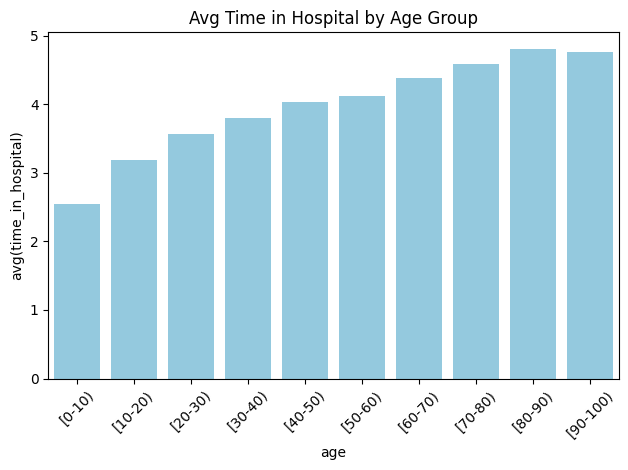

In [213]:

# 1. Average Time in Hospital by Age Group
sns.barplot(data=avg_time_by_age_pd, x="age", y="avg(time_in_hospital)", color="skyblue")
plt.title("Avg Time in Hospital by Age Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

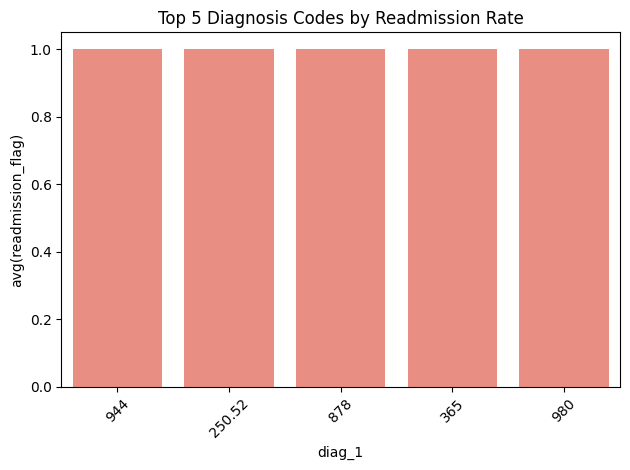

In [214]:


# 2. Top 5 Diagnosis Codes by Readmission Rate
sns.barplot(data=readmit_diag1_pd.head(5), x="diag_1", y="avg(readmission_flag)", color="salmon")
plt.title("Top 5 Diagnosis Codes by Readmission Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


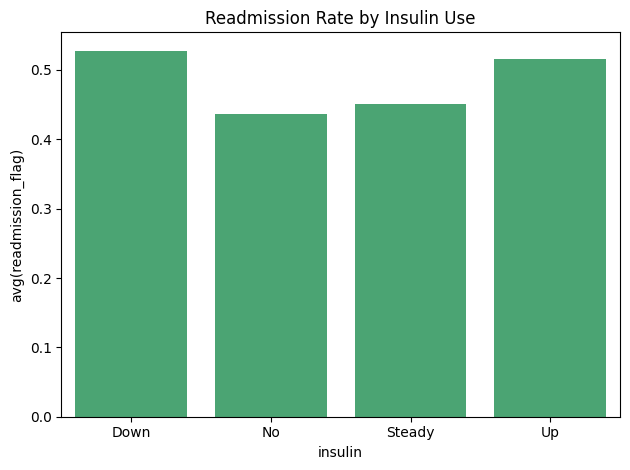

In [215]:

# 3. Readmission Rate by Insulin Use
sns.barplot(data=insulin_readmit_pd, x="insulin", y="avg(readmission_flag)", color="mediumseagreen")
plt.title("Readmission Rate by Insulin Use")
plt.tight_layout()
plt.show()


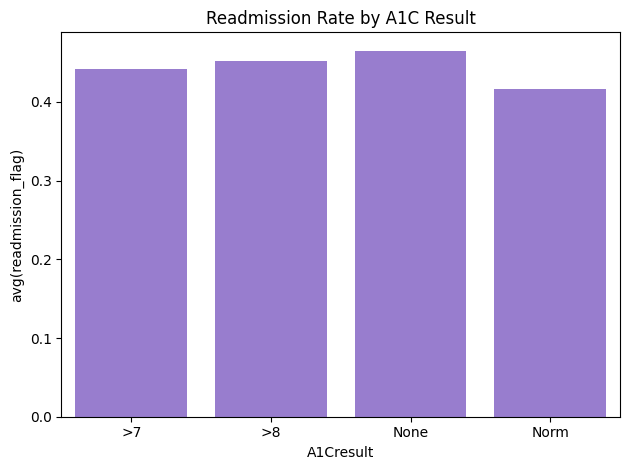

In [216]:
# 4. Readmission Rate by A1C Result
sns.barplot(data=a1c_readmit_pd, x="A1Cresult", y="avg(readmission_flag)", color="mediumpurple")
plt.title("Readmission Rate by A1C Result")
plt.tight_layout()
plt.show()

In [217]:
plt.savefig("Avg Time in Hospital by Age Group.png")
plt.savefig("Top 5 Diagnosis Codes by Readmission Rate.png")
plt.savefig("Readmission Rate by Insulin Use.png")
plt.savefig("Readmission Rate by A1C Result.png")


<Figure size 640x480 with 0 Axes>

Step 5: Performance Optimization

In [218]:
df_partitioned = df_transformed.repartition("age")
df_partitioned.cache()


DataFrame[encounter_id: int, patient_nbr: int, race: string, gender: string, age: string, weight: string, admission_type_id: int, discharge_disposition_id: int, admission_source_id: int, time_in_hospital: int, payer_code: string, medical_specialty: string, num_lab_procedures: int, num_procedures: int, num_medications: int, number_outpatient: int, number_emergency: int, number_inpatient: int, diag_1: string, diag_2: string, diag_3: string, number_diagnoses: int, max_glu_serum: string, A1Cresult: string, metformin: string, repaglinide: string, nateglinide: string, chlorpropamide: string, glimepiride: string, acetohexamide: string, glipizide: string, glyburide: string, tolbutamide: string, pioglitazone: string, rosiglitazone: string, acarbose: string, miglitol: string, troglitazone: string, tolazamide: string, examide: string, citoglipton: string, insulin: string, glyburide-metformin: string, glipizide-metformin: string, glimepiride-pioglitazone: string, metformin-rosiglitazone: string, m

Step 6: Data Export

a) Save cleaned dataset as Parquet

In [219]:
df_transformed.write.mode("overwrite").parquet("/content/cleaned_diabetic_data.parquet")


In [220]:
# summaries
avg_time_by_age = df_transformed.groupBy("age").avg("time_in_hospital").orderBy("age")
readmit_diag1 = df_transformed.groupBy("diag_1").avg("readmission_flag").orderBy(col("avg(readmission_flag)").desc())
insulin_readmit = df_transformed.groupBy("insulin").avg("readmission_flag").orderBy("insulin")
a1c_readmit = df_transformed.groupBy("A1Cresult").avg("readmission_flag").orderBy("A1Cresult")



In [221]:
# Convert to Pandas
avg_time_by_age_pd = avg_time_by_age.toPandas()
readmit_diag1_pd = readmit_diag1.toPandas().head(5)
insulin_readmit_pd = insulin_readmit.toPandas()
a1c_readmit_pd = a1c_readmit.toPandas()



In [222]:
# Save to CSV again for future use
avg_time_by_age_pd.to_csv("/mnt/data/avg_time_by_age.csv", index=False)
readmit_diag1_pd.to_csv("/mnt/data/top_diag_readmit.csv", index=False)
insulin_readmit_pd.to_csv("/mnt/data/insulin_readmit.csv", index=False)
a1c_readmit_pd.to_csv("/mnt/data/a1c_readmit.csv", index=False)

{
    "avg_time_by_age": avg_time_by_age_pd.head(),
    "top_diag_readmit": readmit_diag1_pd,
    "insulin_readmit": insulin_readmit_pd,
    "a1c_readmit": a1c_readmit_pd
}

{'avg_time_by_age':        age  avg(time_in_hospital)
 0   [0-10)               2.546584
 1  [10-20)               3.191027
 2  [20-30)               3.564876
 3  [30-40)               3.799735
 4  [40-50)               4.039649,
 'top_diag_readmit':    diag_1  avg(readmission_flag)
 0     944                    1.0
 1  250.52                    1.0
 2     878                    1.0
 3     365                    1.0
 4     980                    1.0,
 'insulin_readmit':   insulin  avg(readmission_flag)
 0    Down               0.527910
 1      No               0.436999
 2  Steady               0.451068
 3      Up               0.515376,
 'a1c_readmit':   A1Cresult  avg(readmission_flag)
 0        >7               0.441501
 1        >8               0.451801
 2      None               0.465231
 3      Norm               0.417034}